In [1]:
import pandas as pd

DATA_PATH = 'dataframes/price.csv'

df = pd.read_csv(DATA_PATH)
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400


In [2]:
df['Mean'] = (df['Low'] + df['High']) / 2
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000,3.924107
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400,3.591964


In [3]:
steps                = -1
df_predict           = df.copy()
df_predict['Actual'] = df['Mean'].shift(steps)
df_predict.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
0,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000,3.924107,3.728393
1,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393,3.591964
2,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400,3.591964,3.327143


In [4]:
# df_predict[df_predict.isnull().any(axis=1)]
df_predict[~df_predict.notnull().all(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
2766,2019-09-27,55.134998,55.240002,54.32,54.705002,53.521481,101408000,54.780001,NaN


In [5]:
df_predict.dropna(inplace=True)

In [6]:
df_predict['Date'] = pd.to_datetime(df_predict['Date'])
df_predict.index   = df_predict['Date']
df_predict.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Actual
Date,,,,,,,,,
2008-10-01,2008-10-01,3.997143,4.012857,3.835357,3.897143,3.327505,1296484000,3.924107,3.728393
2008-10-02,2008-10-02,3.857500,3.885357,3.571429,3.575000,3.052449,1609364400,3.728393,3.591964
2008-10-03,2008-10-03,3.714286,3.803571,3.380357,3.466786,2.960053,2294398400,3.591964,3.327143


<Axes: xlabel='Date'>

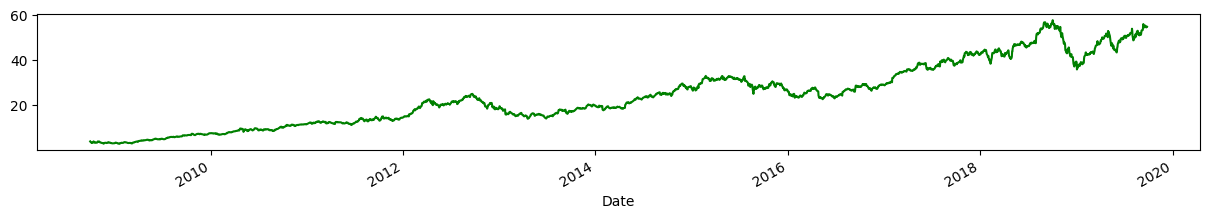

In [7]:
df_predict['Mean'].plot(color='green', figsize=(15, 2))

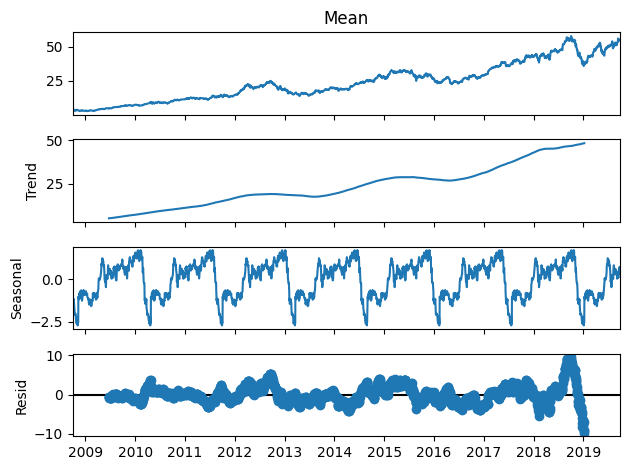

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sd  = sm.tsa.seasonal_decompose(df_predict['Mean'], model='add', period=365)
fig = sd.plot()
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler

cols = ['Low', 'High','Open', 'Close', 'Volume', 'Adj Close', 'Mean']

scaler   = MinMaxScaler(feature_range=(0, 1))
sc_input = scaler.fit_transform(df_predict[cols])
sc_input = pd.DataFrame(sc_input)

X        = pd.DataFrame(sc_input)
for i, col in enumerate(cols):
  X.rename(columns={i: col}, inplace=True)
X.index  = df_predict.index
X.head(2)

,Low,High,Open,Close,Volume,Adj Close,Mean
Date,,,,,,,
2008-10-01,0.019075,0.019558,0.021177,0.019996,0.556275,0.01762,0.019318
2008-10-02,0.014246,0.017258,0.018632,0.014163,0.695398,0.01248,0.015763


In [10]:
scaler    = MinMaxScaler(feature_range=(0, 1))
sc_output = scaler.fit_transform(df_predict[['Actual']])
sc_output = pd.DataFrame(sc_output)

y         = pd.DataFrame(sc_output)
y.rename(columns={0: "Stock Price Next Day"}, inplace= True)
y.index   = df_predict.index
y.head(2)

,Stock Price Next Day
Date,
2008-10-01,0.015763
2008-10-02,0.013284


In [11]:
train_size = int(len(df) * 0.7)
test_size  = int(len(df) - train_size)

X_train, y_train = X[:train_size].dropna(), y[:train_size].dropna()
X_test , y_test  = X[train_size:].dropna(), y[train_size:].dropna()

In [12]:
from pmdarima.arima import auto_arima

step_wise = auto_arima(y_train, exogenous=X_train,
                       start_p=1, start_q=1, max_p=7, max_q=7,
                       d=1, max_d=7,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-15130.709, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-15077.042, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15127.374, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-15132.095, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15075.928, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15130.986, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-15130.275, Time=1.52 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-15131.797, Time=0.41 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.017 seconds


In [13]:
print(step_wise.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1936
Model:               SARIMAX(0, 1, 1)   Log Likelihood                7569.047
Date:                Mon, 25 Mar 2024   AIC                         -15132.095
Time:                        18:34:42   BIC                         -15115.391
Sample:                             0   HQIC                        -15125.952
                               - 1936                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.414      0.157    -7.4e-05       0.000
ma.L1          0.1723      0.013     13.155      0.000       0.147       0.198
sigma2      2.339e-05   3.08e-07     75.974      0.0

In [14]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(y_train, exog=X_train,
                order=(0, 1, 1),
                enforce_invertibility=False, enforce_stationarity=False)

In [25]:
results = model.fit()
predict = results.predict(start=train_size, end=train_size+test_size+(steps)-1, exog=X_test)

c:\Users\jeanl\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
sc_input  = pd.DataFrame(sc_input)
sc_output = pd.DataFrame(sc_output)

act       = pd.DataFrame(sc_output.iloc[train_size:, 0])
act.index = X_test.index
act

,0
Date,
2016-06-10,0.393616
2016-06-13,0.391368
2016-06-14,0.391844
2016-06-15,0.388166
2016-06-16,0.383919
...,...
2019-09-20,0.941503
2019-09-23,0.946476
2019-09-24,0.944114


In [29]:
predict           = pd.DataFrame(predict)
predict.reset_index(drop=True, inplace=True)
predict.index     = X_test.index
predict['Actual'] = act[0]
predict.rename(columns={0: 'Pred'}, inplace=True)
predict

,Pred,Actual
Date,,
2016-06-10,0.396959,0.393616
2016-06-13,0.389980,0.391368
2016-06-14,0.390806,0.391844
2016-06-15,0.389267,0.388166
2016-06-16,0.391202,0.383919
...,...,...
2019-09-20,0.927143,0.941503
2019-09-23,0.931820,0.946476
2019-09-24,0.926898,0.944114


<Axes: xlabel='Date'>

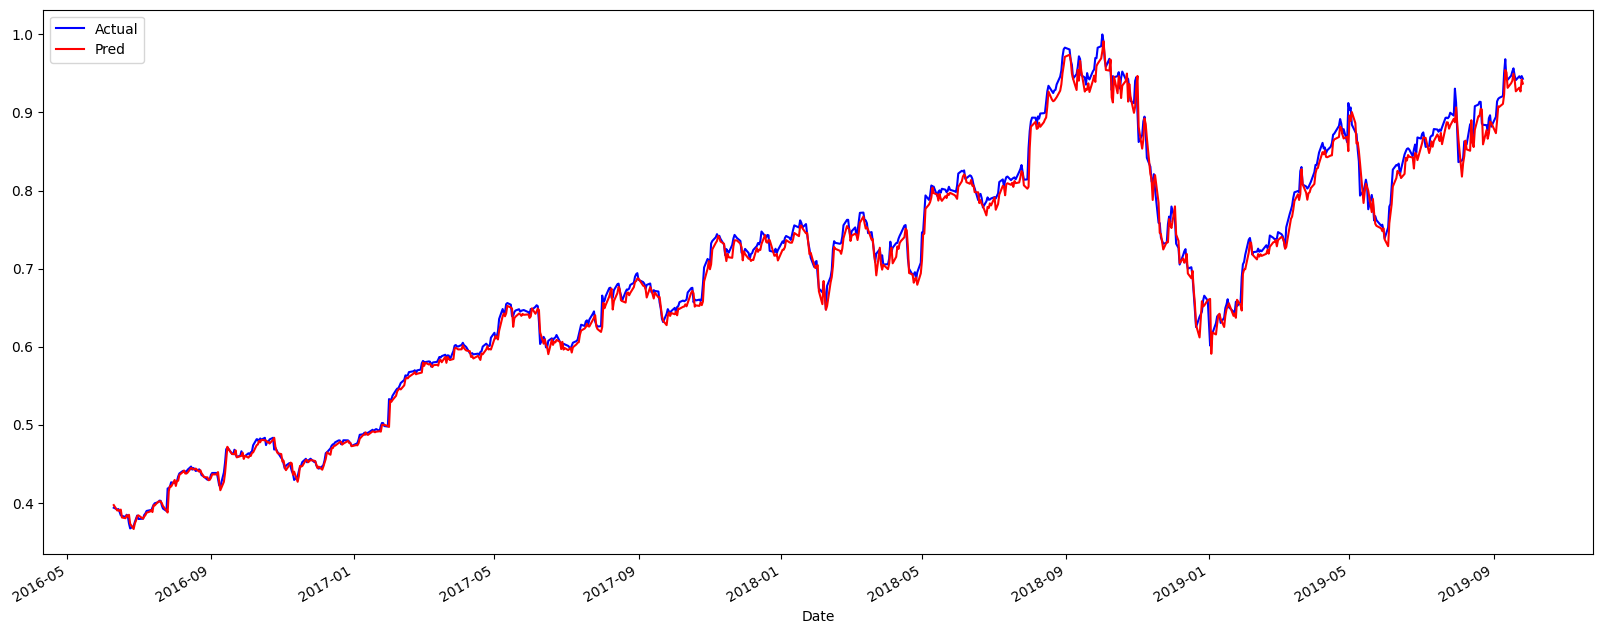

In [30]:
predict['Actual'].plot(figsize=(20, 8), legend=True, color='blue')
predict['Pred'].plot(figsize=(20, 8), legend=True, color='red')

In [31]:
from statsmodels.tools.eval_measures import mse

error = mse(predict['Pred'], predict['Actual'])
error

0.00012945238417055751